In [1]:
import io
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import pandas as pd
import os
from itertools import product
from argparse import Namespace
from order_execution import compute_objective
from table_utils import *

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [2]:
plt.style.use('seaborn-colorblind')
markers = ("^--", "v--", "o--", "s--")
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Comparing methods

In [3]:
results = []
filenames = []
directory = os.fsencode("results/execution")
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".pkl"):
        filenames.append(filename)
        results.append(CPU_Unpickler( open( "results/execution/" + filename, "rb" ) ).load())

num_runs = results[0]["num_runs"] 
gradient_types = {"complete": "Complete PG", "naive": "Naive PG", "ppo": "PPO"}
objectives = {"cost": "Cost", "exponential_low": "Low RA", "exponential_high": "High RA"}
objectives_list = list(objectives.keys())
objective_types = ("cost", "exponential")
param_values = (None, 0.1, 1.0)
baselines = {"twap": "TWAP", "all_trading": "Trading all", "no_trading": "No trading"}
cost_type = ("forsyth", "linear")

columns = ["objective"] + list(baselines.values())
for e1,e2 in product(objectives.values(), gradient_types.values()):
    columns.append(e2+": "+e1)

df_forsyth = pd.DataFrame(columns=columns, index=np.arange(num_runs * len(objectives_list)), dtype="float")
df_linear = pd.DataFrame(columns=columns, index=np.arange(num_runs * len(objectives_list)), dtype="float")
for i in range(len(objectives)):
    df_forsyth.loc[i*num_runs:(i+1)*num_runs-1, "objective"] = objectives[objectives_list[i]]
    df_linear.loc[i*num_runs:(i+1)*num_runs-1, "objective"] = objectives[objectives_list[i]]

names = []
torch_cols = []
for i in range(len(results)):
    r = results[i]
    df = df_forsyth if r["cost_type"] == "forsyth" else df_linear
    args = Namespace(**r)
    using_torch = True
    if "objective" in r:
        if r["objective"] == "exponential":
            objective_name = "exponential_low" if args.exp_param == 0.1 else "exponential_high"
        else:
            objective_name = r["objective"]
    if filenames[i].startswith("order_execution"):
        c = gradient_types[r["gradient_type"]]  + ": " + objectives[objective_name]
    elif filenames[i].startswith("ppo_order_execution"):
        c = gradient_types["ppo"] + ": " + objectives[objective_name] 
        using_torch = False
    else:
        idx = filenames[i].find("order_execution") - 1
        c = baselines[filenames[i][:idx]]
    names.append(c)
    for j in range(len(objectives)):
        args.objective = objectives_list[j].split("_")[0]
        if args.objective == "exponential":
            args.exp_param = param_values[j]
        if using_torch:
            vals = torch.mean(compute_objective(r["endvals"], args), axis=-1)
            df.loc[j*num_runs:(j+1)*num_runs-1, c] = vals.detach().numpy()
        else:
            vals = np.mean(compute_objective(r["endvals"], args, using_torch=False), axis=-1)
            df.loc[j*num_runs:(j+1)*num_runs-1, c] = vals
    torch_cols.append(using_torch)

grouped_linear, code_linear = make_transposed_table(df_linear,
                     ["objective"],
                     [c for c in columns if c != "objective"],
                     num_decimal = 4
                          )

grouped_forsyth, code_forsyth = make_transposed_table(df_forsyth,
                     ["objective"],
                     [c for c in columns if c != "objective"],
                     num_decimal = 4
                          )

table_filename_linear = f"results/execution_linear.tex"
with open(table_filename_linear, "w") as fp:
    fp.write(code_linear)

table_filename_forsyth = f"results/execution_forsyth.tex"
with open(table_filename_forsyth, "w") as fp:
    fp.write(code_forsyth)

In [4]:
grouped_linear

objective                      Cost    Low RA       High RA
TWAP                 mean  0.517605  1.123166  4.824957e+02
                     std   0.004720  0.000782  9.937946e+01
Trading all          mean  1.000000  1.105171  2.718281e+00
                     std   0.000000  0.000000  0.000000e+00
No trading           mean  0.992604  1.339997  2.761132e+06
                     std   0.017266  0.002335  1.224936e+06
Complete PG: Cost    mean  0.523512  1.120153  3.875550e+02
                     std   0.013249  0.005758  1.661980e+02
Naive PG: Cost       mean  0.651904  1.070826  2.644380e+00
                     std   0.012983  0.000954  8.091912e-02
PPO: Cost            mean  0.526944  1.099563  1.242524e+02
                     std   0.014760  0.014102  1.019618e+02
Complete PG: Low RA  mean  0.598263  1.068853  3.532062e+00
                     std   0.006743  0.000589  1.578704e-01
Naive PG: Low RA     mean  0.654736  1.071042  2.631467e+00
                     std   0.018805  0.001396  1.053958e-01
PPO: Low RA          mean  0.586416  1.068664  3.850958e+00
                     std   0.007537  0.000472  2.807536e-01
Complete PG: High RA mean  0.764923  1.080387  2.333139e+00
                     std   0.001997  0.000212  4.301901e-03
Naive PG: High RA    mean  0.798603  1.083718  2.344692e+00
                     std   0.002460  0.000257  3.991538e-03
PPO: High RA         mean  0.764942  1.080400  2.335296e+00
                     std   0.008085  0.000783  1.178597e-03

In [5]:
grouped_forsyth

objective                      Cost    Low RA       High RA
TWAP                 mean  0.519822  1.122349  4.664053e+02
                     std   0.013517  0.001730  9.431031e+01
Trading all          mean  1.242220  1.132267  3.463293e+00
                     std   0.000000  0.000000  0.000000e+00
No trading           mean  1.232441  1.364871  2.124117e+06
                     std   0.022058  0.003111  5.156971e+05
Complete PG: Cost    mean  0.531493  1.120061  3.816357e+02
                     std   0.011700  0.006645  2.319844e+02
Naive PG: Cost       mean  0.679312  1.075401  3.152525e+00
                     std   0.005242  0.000505  3.163765e-02
PPO: Cost            mean  0.536396  1.114733  4.025213e+02
                     std   0.005521  0.016035  3.819219e+02
Complete PG: Low RA  mean  0.629507  1.073390  4.049662e+00
                     std   0.005282  0.000599  8.541898e-02
Naive PG: Low RA     mean  0.718894  1.078161  2.862402e+00
                     std   0.009330  0.000797  3.805993e-02
PPO: Low RA          mean  0.603305  1.073333  5.043252e+00
                     std   0.009524  0.000713  5.359181e-01
Complete PG: High RA mean  0.838120  1.088830  2.628516e+00
                     std   0.003249  0.000334  5.668265e-03
Naive PG: High RA    mean  0.885417  1.093545  2.646441e+00
                     std   0.004008  0.000414  5.455682e-03
PPO: High RA         mean  0.832277  1.088267  2.630988e+00
                     std   0.008962  0.000872  2.224425e-03

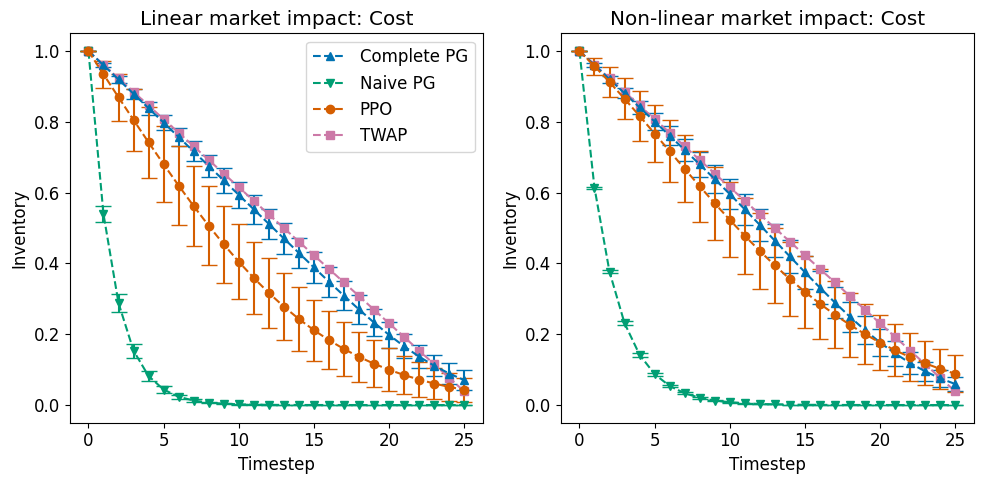

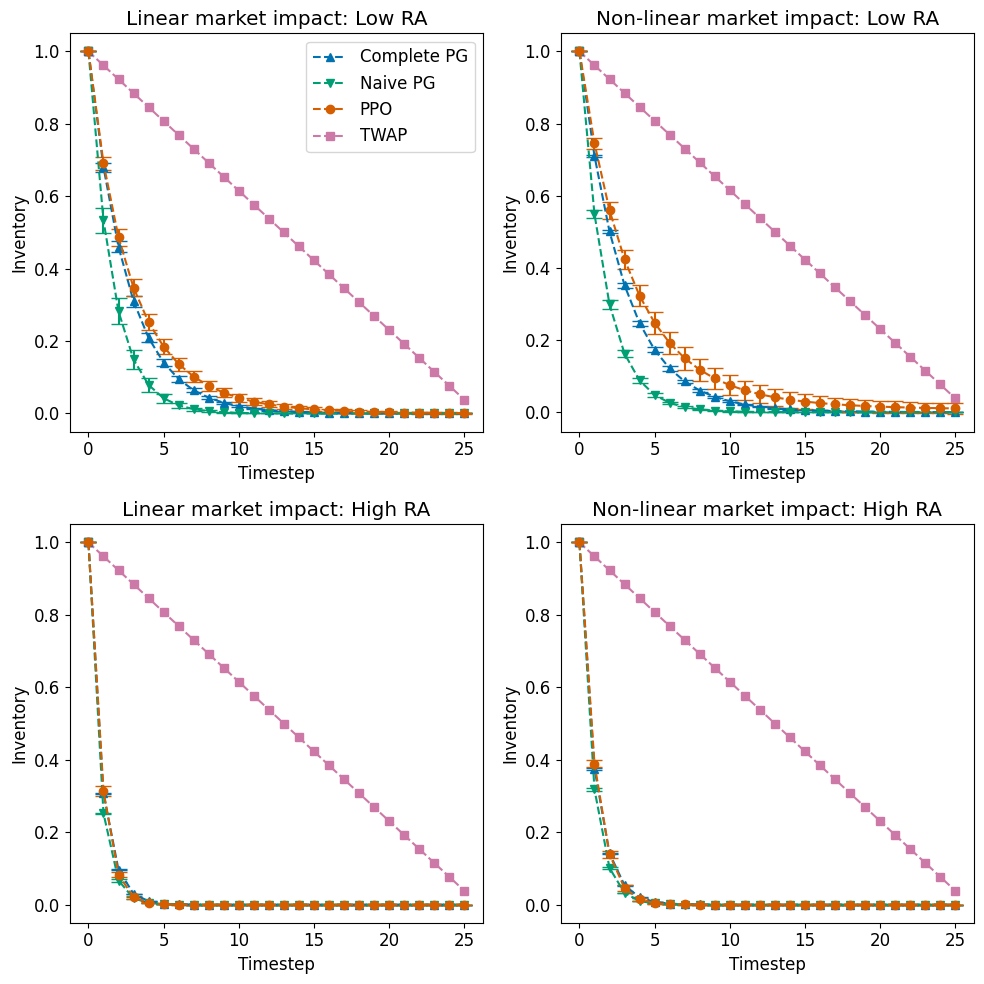

In [6]:
plt.style.use('seaborn-colorblind')
markers = ("^--", "v--", "o--", "s--")
plt.rcParams.update({'font.size': 12})
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
param_vals = (1,2)
figs = [plt.subplots(i, 2, figsize=(10,5*i)) for i in param_vals]
axs = [f[1] for f in figs]
titles = ("Linear market impact", "Non-linear market impact")
xs = np.arange(0,results[0]["n"]+1)

for fig_i in range(len(figs)):
    obj_list = [s for s in objectives_list if s.startswith(objective_types[fig_i])]
    for i in range(2):
        for ii in range(param_vals[fig_i]):
            ax = axs[fig_i][i] if param_vals[fig_i] == 1 else axs[fig_i][ii, i] 
            col_idx = 0
            for j in range(len(results)):
                r = results[j]
                if "objective" in r:
                    if r["objective"] == "exponential":
                        objective_name = "exponential_low" if r["exp_param"] == 0.1 else "exponential_high"
                    else:
                        objective_name = r["objective"]
                if "quantity" in r.keys() and r["objective"] == objective_types[fig_i]:
                    idx = ((1 if r["cost_type"] == "forsyth" else 0), obj_list.index(objective_name))
                    if idx[0] == i and idx[1] == ii:
                        if torch_cols[j]:
                            quantities = torch.mean(r["quantity"], axis=(-1,)).detach().numpy()
                        else:
                            quantities = np.mean(r["quantity"], axis=(-1,))
                        std_values = np.std(quantities, axis=0)
                        mean_values = np.mean(quantities, axis=0)
                        ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, fmt=markers[col_idx], markersize=6)
                        ax.plot((0,),(1,), markers[col_idx], label=names[j].split(": ")[0] , color=cols[col_idx], markersize=6)
                        col_idx += 1

            twap_action = -results[0]["alpha0"]/(results[0]["n"] + 1)
            twap_quantity = 1 + np.arange(0,results[0]["n"]+1)*twap_action
            ax.plot(xs, twap_quantity, markers[3], markersize=6)
            ax.plot((0,),(1,),markers[3], label="TWAP", color=cols[3], markersize=6) 
            ax.set_xlabel("Timestep")
            ax.set_ylabel("Inventory")
            ax.set_title(titles[i] + ": " + objectives[obj_list[ii]])
            if (i, ii) == (0, 0):
                ax.legend()
                
        figs[fig_i][0].tight_layout()
        tikzplotlib.save('results/execution_quantity_{}.tex'.format(objective_types[fig_i]), figure=figs[fig_i][0], encoding='utf-8')
plt.show()

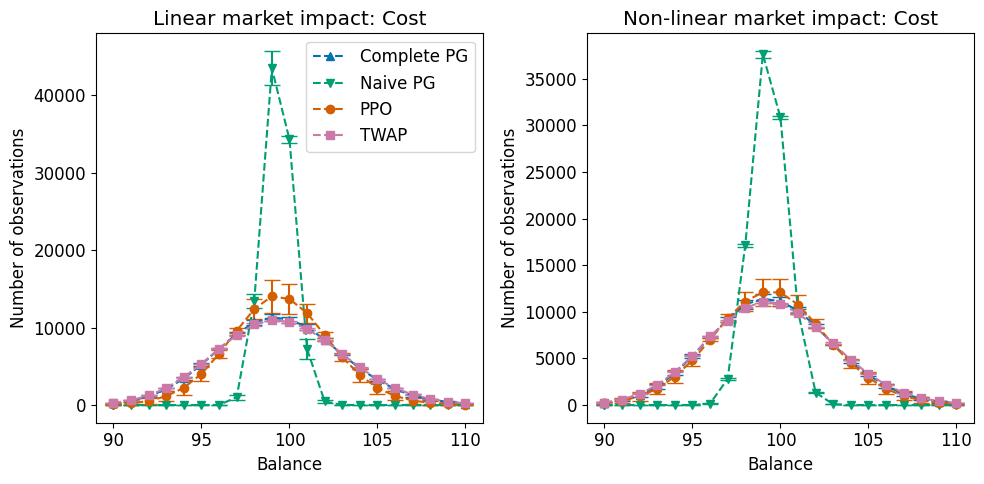

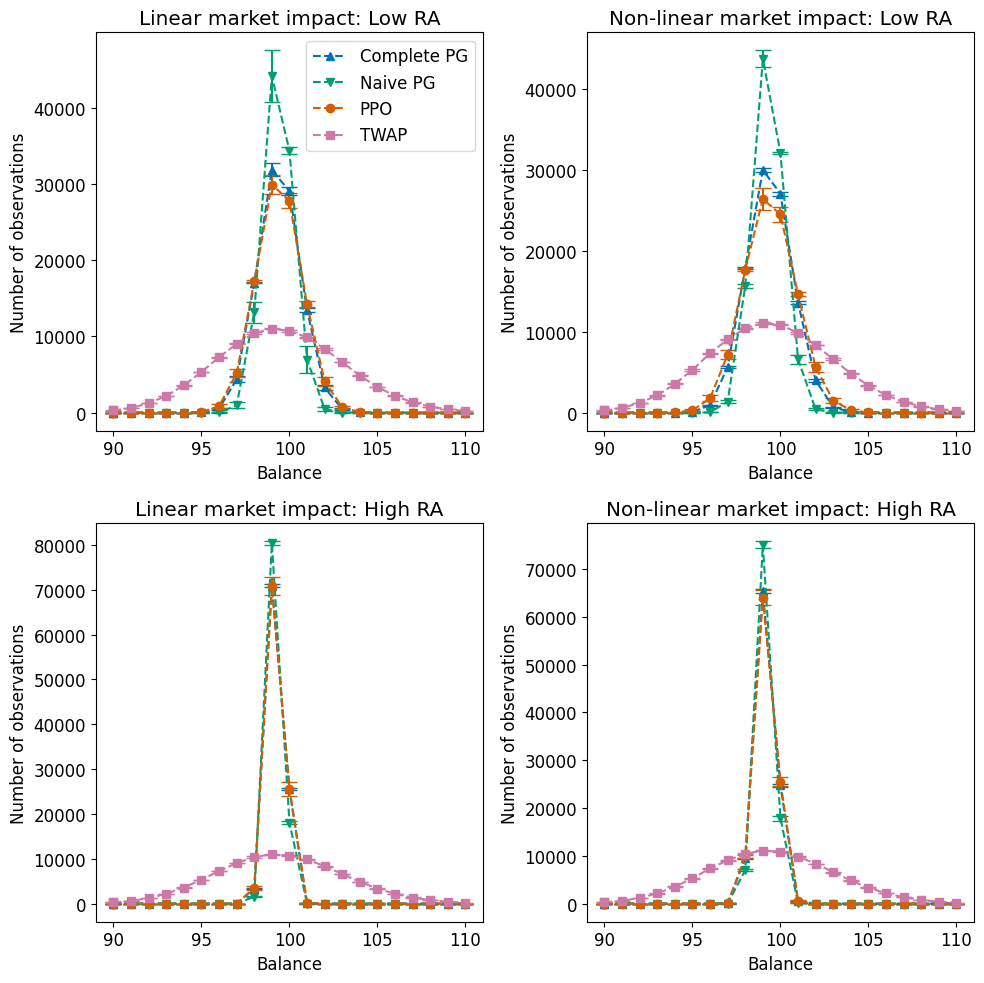

In [7]:
plt.style.use('seaborn-colorblind')
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
param_vals = (1,2)
figs = [plt.subplots(i, 2, figsize=(10,5*i)) for i in param_vals]
axs = [f[1] for f in figs]
titles = ("Linear market impact", "Non-linear market impact")
bins = np.arange(89, 111) + 0.5
xs = (bins[1:] + bins[:-1])/2

for fig_i in range(len(figs)):
    obj_list = [s for s in objectives_list if s.startswith(objective_types[fig_i])]
    for i in range(2):
        for ii in range(param_vals[fig_i]):
            ax = axs[fig_i][i] if param_vals[fig_i] == 1 else axs[fig_i][ii, i] 
            col_idx = 0
            for j in range(len(results)):
                r = results[j]
                if "objective" in r:
                    if r["objective"] == "exponential":
                        objective_name = "exponential_low" if r["exp_param"] == 0.1 else "exponential_high"
                    else:
                        objective_name = r["objective"]
                if "quantity" in r.keys() and r["objective"] == objective_types[fig_i]:
                    idx = ((1 if r["cost_type"] == "forsyth" else 0), obj_list.index(objective_name))
                    if idx[0] == i and idx[1] == ii:
                        if torch_cols[j]:
                            endvals = r["endvals"].detach().numpy()
                        else:
                            endvals = r["endvals"]
                        freqs = np.stack([np.histogram(endvals[n,:], bins=bins, density=False)[0] for n in range(num_runs)])  
                        std_values = np.std(freqs, axis=0)
                        mean_values = np.mean(freqs, axis=0)
                        ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, fmt=markers[col_idx], markersize=6)
                        ax.plot(xs[0], mean_values[0], markers[col_idx], label=names[j].split(": ")[0] , color=cols[col_idx], markersize=6)
                        col_idx += 1

            for j in range(len(results)):
                r = results[j]
                if "objective" not in r and names[j] == "TWAP":
                    idx = ((1 if r["cost_type"] == "forsyth" else 0), ii)
                else:
                    idx = ((1 if r["cost_type"] == "forsyth" else 0),-1)
                if idx[0] == i and idx[1] == ii:
                    freqs = np.stack([np.histogram(r["endvals"][n,:], bins=bins, density=False)[0] for n in range(num_runs)])  
                    std_values = np.std(freqs, axis=0)
                    mean_values = np.mean(freqs, axis=0)
                    ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, color=cols[col_idx], fmt=markers[col_idx], markersize=6)
                    ax.plot(xs[0], mean_values[0], markers[col_idx], label=names[j], color=cols[col_idx], markersize=6)
                    col_idx += 1
            ax.set_xlabel("Balance")
            ax.set_ylabel("Number of observations")
            ax.set_title(titles[i] + ": " + objectives[obj_list[ii]])
    
            if (i, ii) == (0, 0):
                ax.legend()
    figs[fig_i][0].tight_layout()

    tikzplotlib.save('results/execution_histogram_{}.tex'.format(objective_types[fig_i]), figure=figs[fig_i][0], encoding='utf-8')
plt.show()